https://www.fleaflicker.com/forums/site-announcements/topics/quantifying-luck-in-head-to-head-fantasy-leagues-13680

In [1]:
import psycopg2
import configparser
import pandas as pd

In [2]:
# get data from sql server
parser = configparser.ConfigParser()
parser.read('database.ini')
params = parser.items('postgresql')
db = {}
for param in params:
    db[param[0]] = param[1]
conn = psycopg2.connect(**db)
cur = conn.cursor()
cur.execute("SELECT * FROM luck;")
df = cur.fetchall()
conn.close()

In [3]:
# wrangle data
df = pd.DataFrame(df, 
    columns= ['Week', 'Nick', 'Mark', 'Sawyer','Caleb', 'Daniel', 'Metch', 'Tonia', 'Dennis']
    ).drop(['Week'], axis = 1)

In [4]:
df.describe()

,Nick,Mark,Sawyer,Caleb,Daniel,Metch,Tonia,Dennis
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,-13.066667,7.800000,-8.600000,7.666667,-7.933333,1.800000,4.666667,7.666667
std,37.208806,35.635456,46.986016,34.864363,41.014748,33.304225,34.574282,26.781301
min,-86.000000,-86.000000,-86.000000,-71.000000,-86.000000,-43.000000,-71.000000,-14.000000
25%,-36.000000,0.000000,-35.500000,-7.000000,-43.000000,-29.000000,-14.000000,-7.000000
50%,-14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,29.000000,7.000000,29.000000,29.000000,21.500000,41.500000,0.000000
max,57.000000,43.000000,71.000000,57.000000,43.000000,71.000000,57.000000,71.000000


In [5]:
import scipy.stats as stats
import matplotlib.pyplot as plt

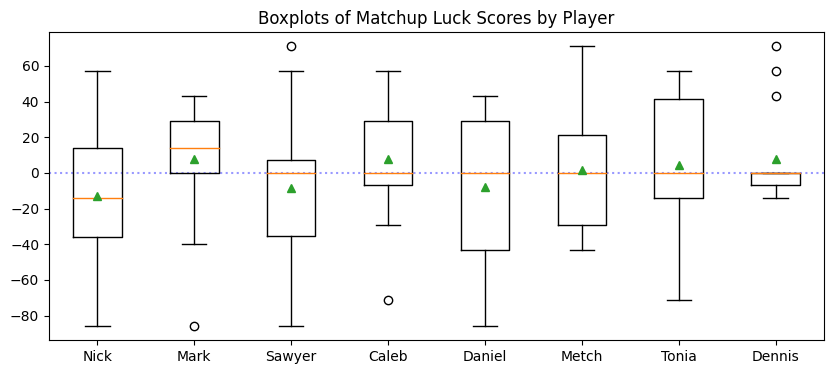

In [6]:
plt.figure(figsize = (10,4))
plt.axhline(y = 0, color = 'blue', linestyle = ':', alpha = 0.4)
plt.boxplot(
    df,
    labels = ['Nick', 'Mark', 'Sawyer','Caleb', 'Daniel', 'Metch', 'Tonia', 'Dennis'],
    showmeans = True
)
plt.title("Boxplots of Matchup Luck Scores by Player")
plt.show()

It is clear that the means are lower for some teams than others. The medians are, perhaps unsurprisingly, almost all 0 (these luck scores are calculated such that within every week the sum of the luck scores is 0). The standard deviations appear to be very large relative to the means. There is not likely a statistically significant difference in the means but lets start with a simple ANOVA to make sure anyways.

In [7]:
stats.f_oneway(
    df['Nick'],
    df['Mark'],
    df['Sawyer'],
    df['Caleb'],
    df['Daniel'],
    df['Metch'],
    df['Tonia'],
    df['Dennis']
    )

F_onewayResult(statistic=0.8125738140940422, pvalue=0.5786681370744882)

Not surprisingly, there is no statistically significant difference in the means. The variances are just too large. 

We can explore this further by looking at Mark's team (the best average) against Nick's team (the worst average). We'll do this a couple of ways. First we use a Bayesian approach to try to estimate the difference in means. A frequentist approach to this problem will likely not find a significant result, and that's fine, but it is more interesting to see *how* the two teams luck was different rather.

In [8]:
import pymc as pm
import numpy as np
import arviz as az
rng = np.random.default_rng(seed=100)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


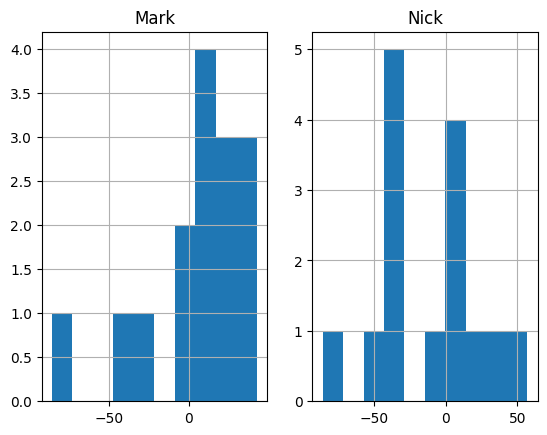

In [9]:
fig, ax = plt.subplots(1,2)
df['Mark'].hist(ax = ax[0])
df['Nick'].hist(ax = ax[1])
ax[0].set_title('Mark')
ax[1].set_title('Nick')
plt.show()

Mark's team definitely had more consistent good matchup luck with only 3 games below 0. Nick's luck is considerably more spread out with an average below 0. I set up the Bayesian model below. I borrow heavily from the code found here: https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/BEST.html. 

Our sample sizes are small with only 15 observations, so it is highly likely that were the season to continue, these matchup luck distributions would have normalized. For now, the base probability model for these scores is the famous T distribution which requires us to model the mean, the variance (and its inverse, precision), and the degrees of freedom.

In [10]:
# restructure df to make the pooled means/stds
y1 = list(df['Mark'])
y2 = list(df['Nick'])
y = y1 + y2
df_2 = pd.DataFrame(
    dict(luck = y, team = np.r_[['Mark']*15, ['Nick']*15])
)

In [11]:
mu_mean = df_2.luck.mean()
mu_std = df_2.luck.std()*2

with pm.Model() as model:
    mark_mean = pm.Normal("mark_mean", mu = mu_mean, sigma = mu_std)
    nick_mean = pm.Normal("nick_mean",mu = mu_mean, sigma = mu_std)

I choose a uniform distribution for the team standard deviations. The scores are bounded at +/-100, and the standard deviation is unlikely to be the top of this range. We have also seen empirically above that it is also not close to 0. 

In [12]:
sig_low = 10
sig_high = 60

with model:
    mark_std = pm.Uniform("mark_std", lower = sig_low, upper = sig_high)
    nick_std = pm.Uniform("nick_std", lower = sig_low, upper = sig_high)

The T distribution also has a parameter for degrees of freedom. Following the guidance from Kruschke (2012) and the PYMC docs, using an exponential distribution with a mean of 30 allows the high probability region to cover a range that would cause the distribution to be particularly 'fat-tailed' to normal.

In [13]:
with model:
    v = pm.Exponential("v_minus_one", 1/29.0) + 1

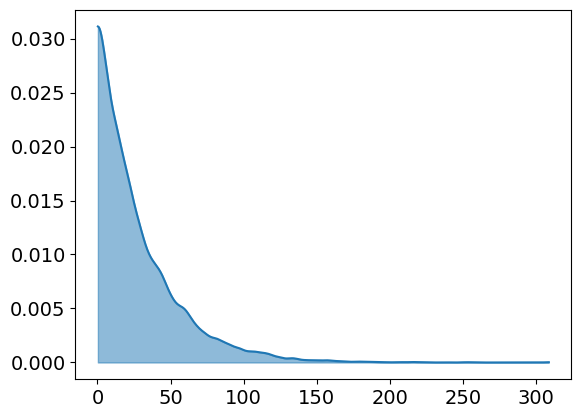

In [19]:
az.plot_kde(rng.exponential(scale=30, size=10000), fill_kwargs={"alpha": 0.5})
plt.show()

Since PYMC wants the variance in the form of precision we need to transform it:

In [14]:
with model:
    lam_mark = mark_std**-2
    lam_nick = nick_std**-2

    mark = pm.StudentT("Mark", nu = v, mu = mark_mean, lam = lam_mark, observed = df['Mark'])
    nick = pm.StudentT("Nick", nu = v, mu = nick_mean, lam = lam_nick, observed = df['Nick'])

This effect size 

In [15]:
with model:
    diff_of_means = pm.Deterministic("difference of means", mark_mean - nick_mean)
    diff_of_stds = pm.Deterministic("difference of stds", mark_std - nick_std)
    effect_size = pm.Deterministic(
        "effect size", 
        diff_of_means/np.sqrt((mark_std**2 + nick_std**2)/2)
    )

In [16]:
with model:
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mark_mean, nick_mean, mark_std, nick_std, v_minus_one]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 21 seconds.


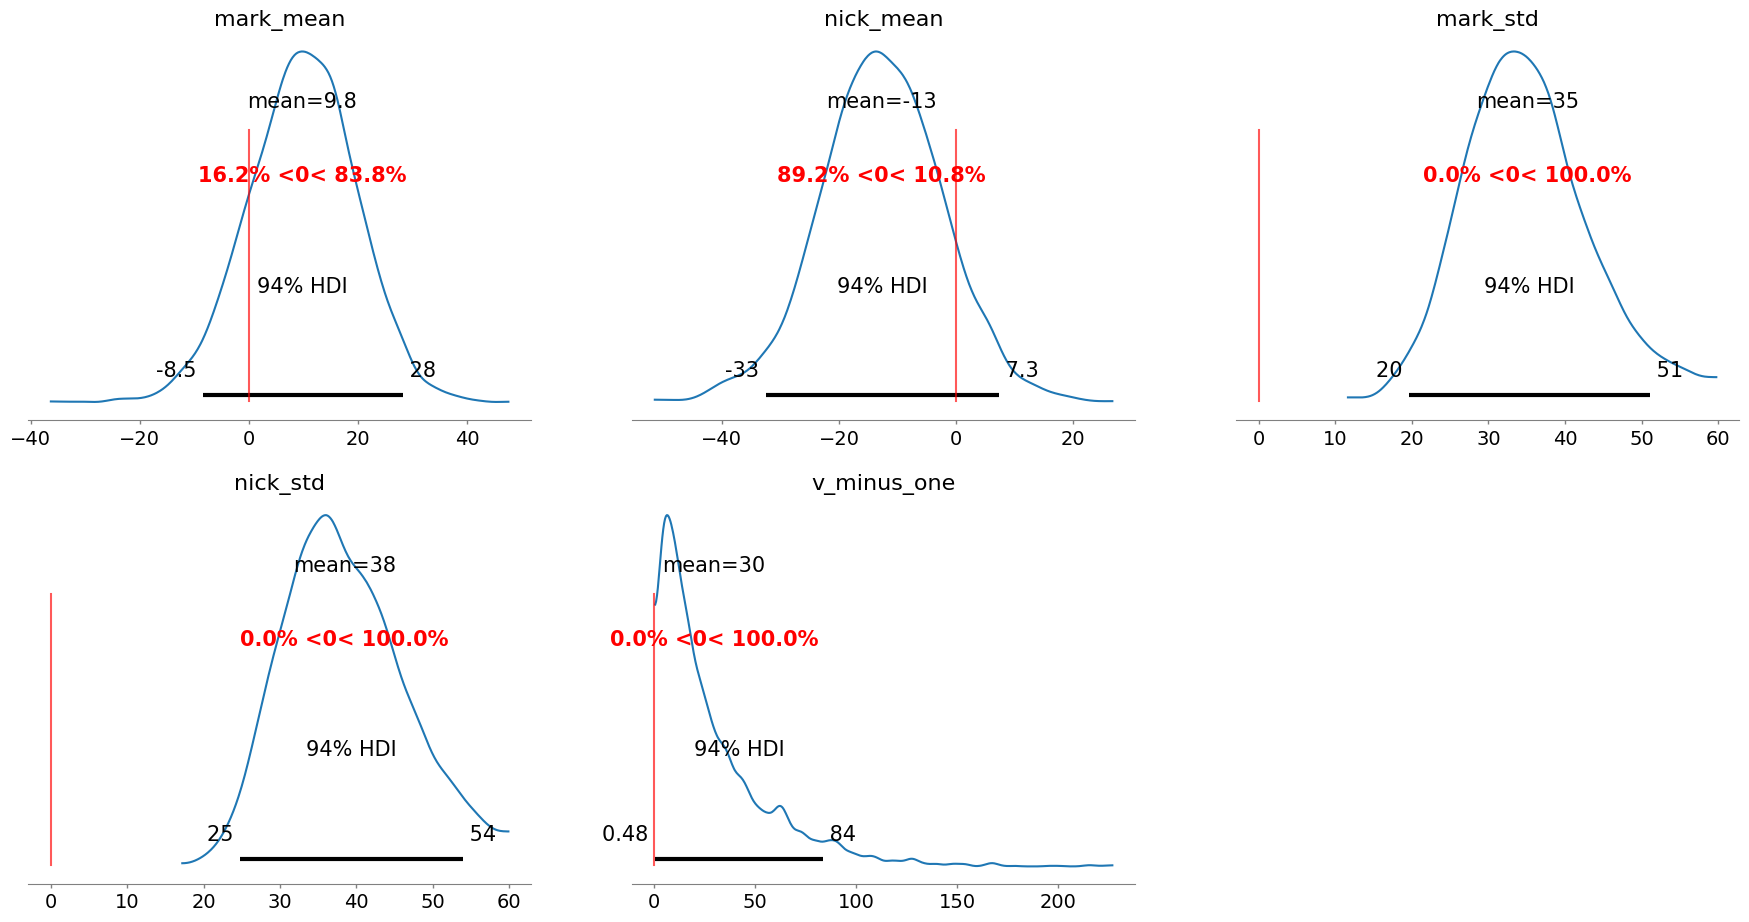

In [17]:
az.plot_posterior(
    trace,
    var_names = ["mark_mean", "nick_mean", "mark_std", "nick_std", "v_minus_one"],
    ref_val=0,
    ref_val_color="red"
)
plt.show()

In [18]:
az.summary(trace, var_names = ["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,22.574,14.592,-5.109,49.715,0.281,0.201,2707.0,2363.0,1.0
difference of stds,-3.344,10.985,-24.204,17.295,0.226,0.193,2368.0,2086.0,1.0
effect size,0.631,0.424,-0.178,1.408,0.009,0.006,2314.0,2378.0,1.0
